In [148]:
# pip install pydantic
# pip install pydantic-settings
# pip install xlrd
# pip install pandas-profiling
# pip install ydata-profiling

In [149]:
import pandas as pd
import numpy as np
from pydantic_settings import BaseSettings
from ydata_profiling import ProfileReport
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [150]:
df = pd.read_excel(r"C:\\Users\Alex\Documents\GitHub\Responsible Lenders - ALM\default of credit card clients.xls", header=1)
# df

In [151]:
# profile = ProfileReport(df, title="The Profile")
# profile

In [195]:
data = df.drop(["ID"],axis=1).rename(columns={"PAY_0":"PAY_1","default payment next month":"DEFAULT"}).replace({"EDUCATION":{0:4,5:4,6:4},"MARRIAGE":{0:3}})
# data.PAY_1.value_counts()
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [153]:
# X = data.drop(["DEFAULT"],axis=1)
# y = data.DEFAULT

data_train, data_test = train_test_split(data.copy(),
                                         shuffle = True,
                                         random_state = 42,
                                         test_size = 0.2,
                                         stratify = data["DEFAULT"])

# print(data.DEFAULT.value_counts(normalize=True))
# print(data_train.DEFAULT.value_counts(normalize=True))
# print(data_test.DEFAULT.value_counts(normalize=True))

In [154]:
# X_train = data_train.drop(["DEFAULT"],axis=1)
# y_train = data_train.DEFAULT
# X_test = data_test.drop(["DEFAULT"],axis=1)
# y_test = data_test.DEFAULT


kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 42)

In [155]:
# i = 1
# for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
#     print("Split",i)
#     print("CV Training Set Split")
#     print(data_train.iloc[train_index].DEFAULT.value_counts(normalize=True))
    
#     print()
    
#     print("CV Holdout Set Split")
#     print(data_train.iloc[test_index].DEFAULT.value_counts(normalize=True))
    
#     print()
#     print("+++++++++++++++++++")
#     print()
    
#     i = i + 1

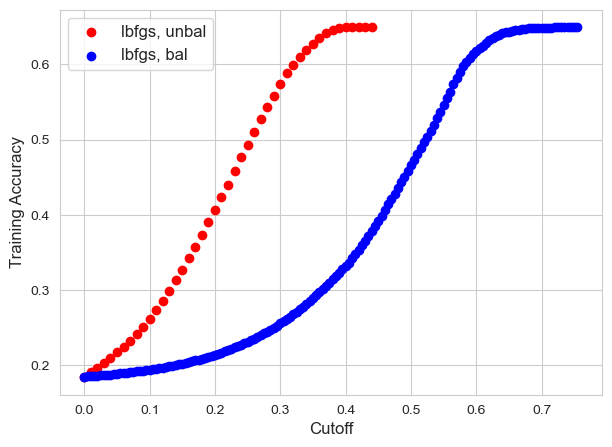

In [245]:
# Accuracy:  solver = "lbfgs", class_weight = None  vs  solver = "lbfgs", class_weight = "balanced"

log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(penalty=None,max_iter=1000,class_weight="balanced")
cutoffs = np.arange(0,0.45,0.01)
cutoffs_bal = np.arange(0,0.76,0.005)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    accuracies = []
    accuracies_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        accuracies.append(np.sum(y_train_pred == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        accuracies_bal.append(np.sum(y_train_pred_bal == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    avg = avg + accuracies
    avg_bal = avg_bal + accuracies_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "lbfgs, unbal",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "lbfgs, bal",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)
plt.legend(fontsize=12)
plt.show()

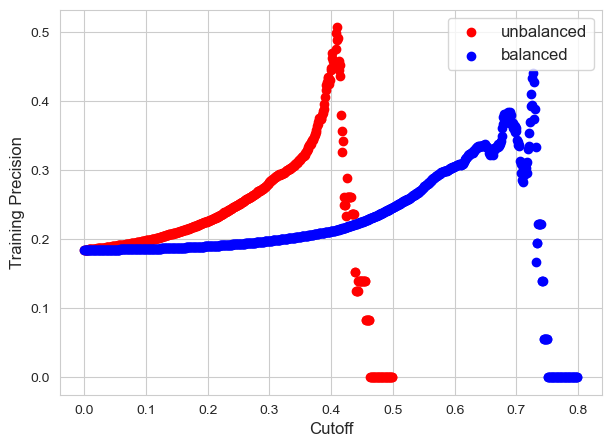

In [193]:
# Precision:  class_weight = None  vs  class_weight = "balanced"


log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(penalty=None,max_iter=1000,class_weight="balanced")
cutoffs = np.arange(0,0.5,0.001)
cutoffs_bal = np.arange(0,0.8,0.001)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    precisions = []
    precisions_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        precisions.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        precisions_bal.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred_bal,zero_division=0.0))
    
    avg = avg + precisions
    avg_bal = avg_bal + precisions_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "unbalanced",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "balanced",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Precision",fontsize=12)
plt.legend(fontsize=12)
plt.show()

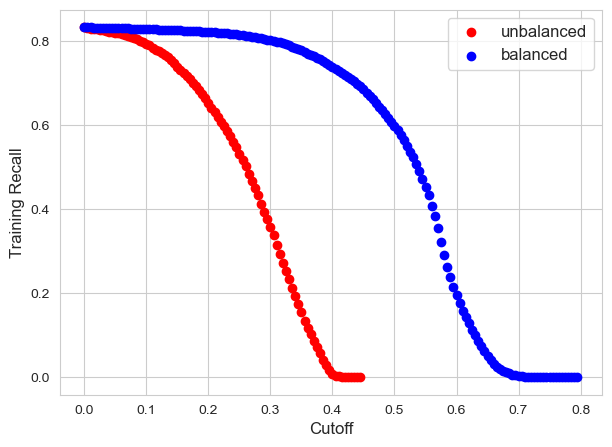

In [194]:
# Recall:  class_weight = None  vs  class_weight = "balanced"

log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(penalty=None,max_iter=1000,class_weight="balanced")
cutoffs = np.arange(0,0.45,0.005)
cutoffs_bal = np.arange(0,0.8,0.005)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    recalls = []
    recalls_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        recalls.append(recall_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        recalls_bal.append(recall_score(data_train.iloc[train_index].DEFAULT,y_train_pred_bal,zero_division=0.0))
    
    avg = avg + recalls
    avg_bal = avg_bal + recalls_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "unbalanced",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "balanced",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Recall",fontsize=12)
plt.legend(fontsize=12)
plt.show()

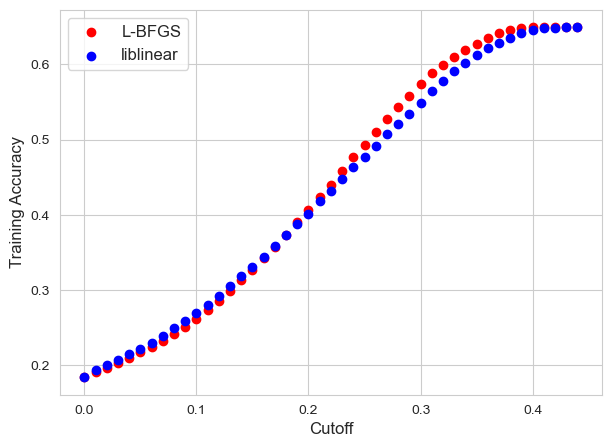

In [200]:
# Accuracy:  solver = "lbfgs"  vs  solver = "liblinear"

log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(max_iter=1000,solver="liblinear")
cutoffs = np.arange(0,0.45,0.01)
cutoffs_bal = np.arange(0,0.45,0.01)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    accuracies = []
    accuracies_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        accuracies.append(np.sum(y_train_pred == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        accuracies_bal.append(np.sum(y_train_pred_bal == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    avg = avg + accuracies
    avg_bal = avg_bal + accuracies_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "L-BFGS",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)
plt.legend(fontsize=12)
plt.show()

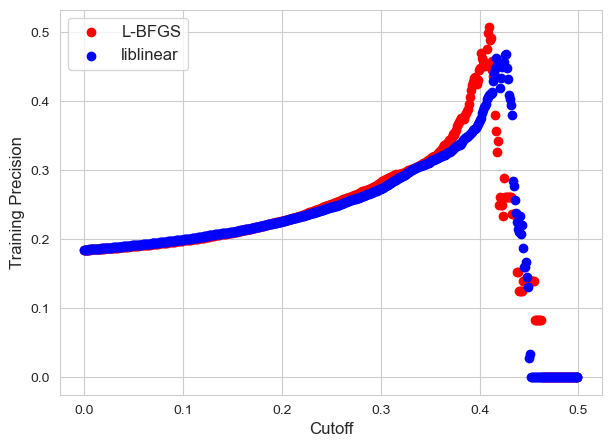

In [202]:
# Precision:  solver = "lbfgs"  vs  solver = "liblinear"


log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(max_iter=1000,solver="liblinear")
cutoffs = np.arange(0,0.5,0.001)
cutoffs_bal = np.arange(0,0.5,0.001)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    precisions = []
    precisions_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        precisions.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        precisions_bal.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred_bal,zero_division=0.0))
    
    avg = avg + precisions
    avg_bal = avg_bal + precisions_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "L-BFGS",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Precision",fontsize=12)
plt.legend(fontsize=12)
plt.show()

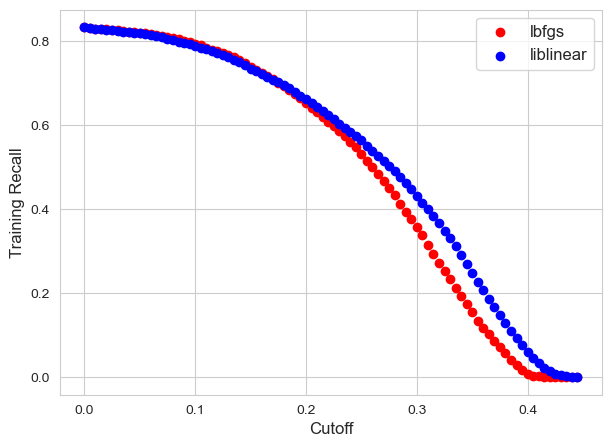

In [203]:
# Recall:  solver = "lbfgs"  vs  solver = "liblinear"

log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(max_iter=1000,solver="liblinear")
cutoffs = np.arange(0,0.45,0.005)
cutoffs_bal = np.arange(0,0.45,0.005)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    recalls = []
    recalls_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        recalls.append(recall_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        recalls_bal.append(recall_score(data_train.iloc[train_index].DEFAULT,y_train_pred_bal,zero_division=0.0))
    
    avg = avg + recalls
    avg_bal = avg_bal + recalls_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "lbfgs",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Recall",fontsize=12)
plt.legend(fontsize=12)
plt.show()

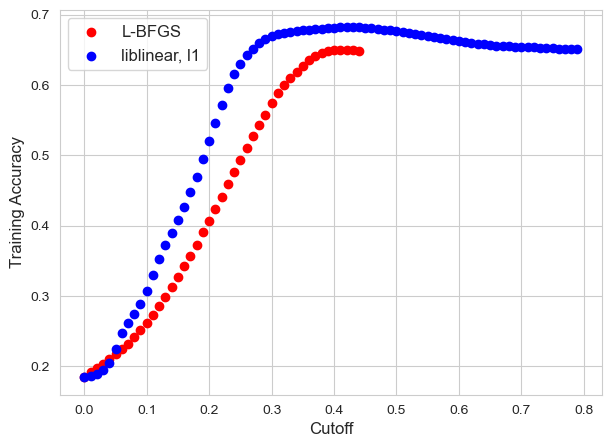

In [215]:
# Accuracy:  solver = "lbfgs"  vs  solver = "liblinear", penalty = "l1"

log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear")
cutoffs = np.arange(0,0.45,0.01)
cutoffs_bal = np.arange(0,0.8,0.01)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    accuracies = []
    accuracies_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        accuracies.append(np.sum(y_train_pred == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        accuracies_bal.append(np.sum(y_train_pred_bal == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    avg = avg + accuracies
    avg_bal = avg_bal + accuracies_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "L-BFGS",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear, l1",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)
plt.legend(fontsize=12)
plt.show()

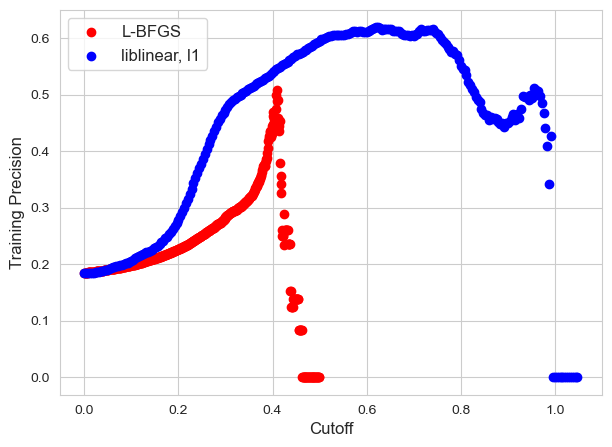

In [211]:
# Precision:  solver = "lbfgs"  vs  solver = "liblinear", penalty = "l1"


log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear")
cutoffs = np.arange(0,0.5,0.001)
cutoffs_bal = np.arange(0,1.05,0.004)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    precisions = []
    precisions_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        precisions.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        precisions_bal.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred_bal,zero_division=0.0))
    
    avg = avg + precisions
    avg_bal = avg_bal + precisions_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "L-BFGS",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear, l1",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Precision",fontsize=12)
plt.legend(fontsize=12)
plt.show()

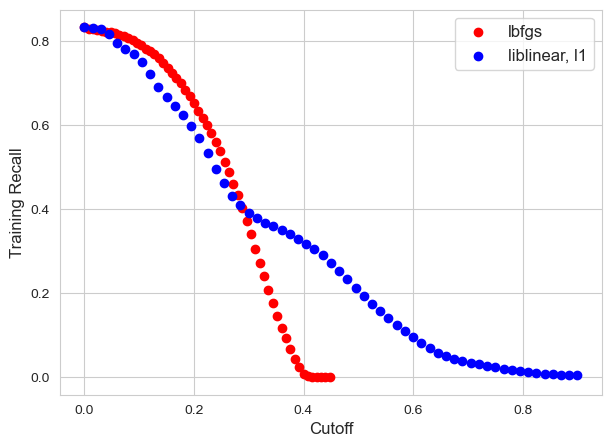

In [212]:
# Recall:  solver = "lbfgs"  vs  solver = "liblinear", penalty = "l1"

log_reg = LogisticRegression(penalty=None,max_iter=1000)
log_reg_bal = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear")
cutoffs = np.arange(0,0.45,0.008)
cutoffs_bal = np.arange(0,0.9,0.015)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    recalls = []
    recalls_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        recalls.append(recall_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        recalls_bal.append(recall_score(data_train.iloc[train_index].DEFAULT,y_train_pred_bal,zero_division=0.0))
    
    avg = avg + recalls
    avg_bal = avg_bal + recalls_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "lbfgs",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear, l1",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Recall",fontsize=12)
plt.legend(fontsize=12)
plt.show()

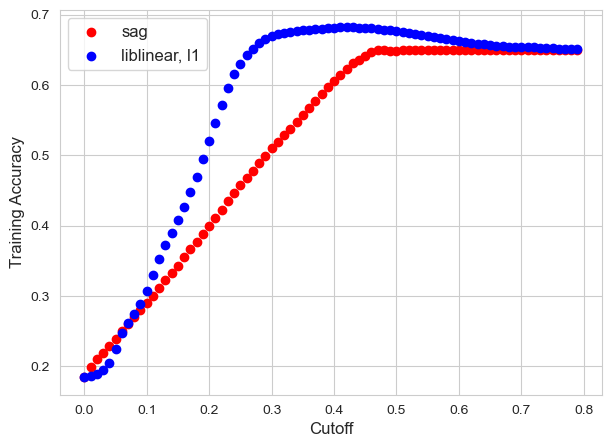

In [226]:
# Accuracy:  solver = "sag", penalty = None  vs  solver = "liblinear", penalty = "l1"

log_reg = LogisticRegression(penalty=None,max_iter=10000,solver="sag")
log_reg_bal = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear")
cutoffs = np.arange(0,0.8,0.01)
cutoffs_bal = np.arange(0,0.8,0.01)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    accuracies = []
    accuracies_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        accuracies.append(np.sum(y_train_pred == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        accuracies_bal.append(np.sum(y_train_pred_bal == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    avg = avg + accuracies
    avg_bal = avg_bal + accuracies_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "sag",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear, l1",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)
plt.legend(fontsize=12)
plt.show()

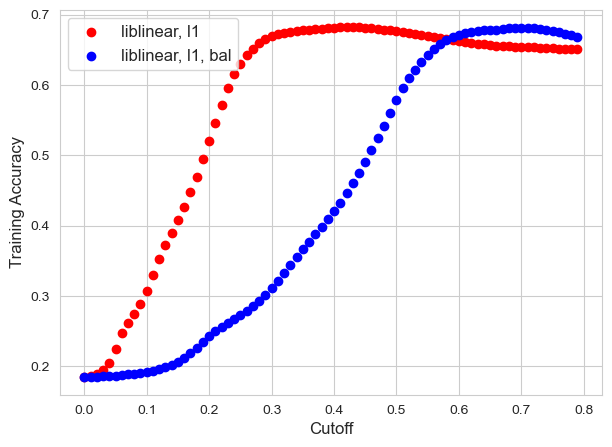

In [230]:
# Accuracy:  solver = "liblinear", penalty = "l1"  vs  solver = "liblinear", penalty = "l1", class_weight = "balanced"

log_reg = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear")
log_reg_bal = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear",class_weight="balanced")
cutoffs = np.arange(0,0.8,0.01)
cutoffs_bal = np.arange(0,0.8,0.01)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    accuracies = []
    accuracies_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        accuracies.append(np.sum(y_train_pred == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        accuracies_bal.append(np.sum(y_train_pred_bal == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
    
    avg = avg + accuracies
    avg_bal = avg_bal + accuracies_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "liblinear, l1",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear, l1, bal",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)
plt.legend(fontsize=12)
plt.show()

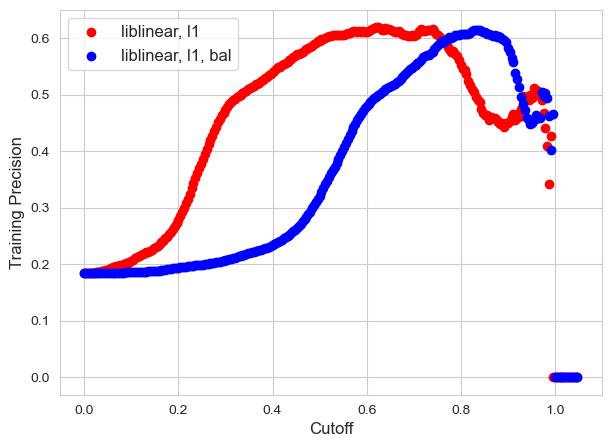

In [229]:
# Accuracy:  solver = "liblinear", penalty = "l1"  vs  solver = "liblinear", penalty = "l1", class_weight = "balanced"


log_reg = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear")
log_reg_bal = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear",class_weight="balanced")
cutoffs = np.arange(0,1.05,0.004)
cutoffs_bal = np.arange(0,1.05,0.004)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    precisions = []
    precisions_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        precisions.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        precisions_bal.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred_bal,zero_division=0.0))
    
    avg = avg + precisions
    avg_bal = avg_bal + precisions_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "liblinear, l1",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear, l1, bal",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Precision",fontsize=12)
plt.legend(fontsize=12)
plt.show()

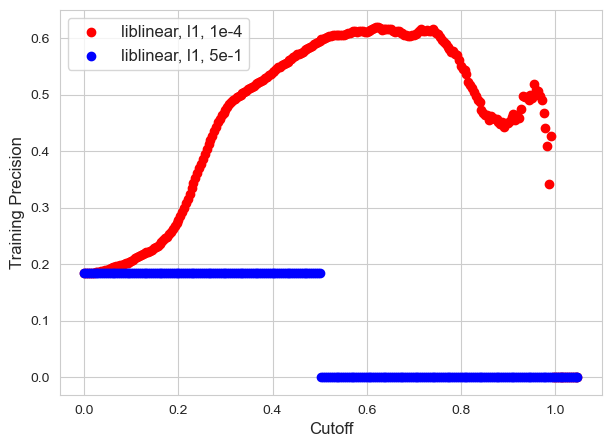

In [241]:
# Accuracy:  solver = "liblinear", penalty = "l1"  vs  solver = "liblinear", penalty = "l1", class_weight = "balanced"


log_reg = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear")
log_reg_bal = LogisticRegression(penalty="l1",max_iter=1000,solver="liblinear",tol=4.8)
cutoffs = np.arange(0,1.05,0.004)
cutoffs_bal = np.arange(0,1.05,0.004)
avg = np.zeros(shape=len(cutoffs))
avg_bal = np.zeros(shape=len(cutoffs_bal))
i = 1

for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
    log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    log_reg_bal.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
    y_prob_bal = log_reg_bal.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]
    
    precisions = []
    precisions_bal = []
    
    for cutoff in cutoffs:
        y_train_pred = 1*(y_prob >= cutoff)
        precisions.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
    
    for cutoff in cutoffs_bal:
        y_train_pred_bal = 1*(y_prob_bal >= cutoff)
        precisions_bal.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred_bal,zero_division=0.0))
    
    avg = avg + precisions
    avg_bal = avg_bal + precisions_bal
    i = i + 1
    
    
plt.figure(figsize=(7,5))
plt.scatter(cutoffs,
            avg/i,
            label = "liblinear, l1, 1e-4",
            c = "red")
plt.scatter(cutoffs_bal,
            avg_bal/i,
            label = "liblinear, l1, 5e-1",
            c = "blue")
plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Precision",fontsize=12)
plt.legend(fontsize=12)
plt.show()

C:\Users\Alex\AppData\Local\Temp\ipykernel_7788\1978326464.py:151: RuntimeWarning: invalid value encountered in divide
  lg["avg_NPV"] = (lg["avg_tn"]/(lg["avg_tn"]+lg["avg_fn"]))
C:\Users\Alex\AppData\Local\Temp\ipykernel_7788\1978326464.py:151: RuntimeWarning: invalid value encountered in divide
  lg["avg_NPV"] = (lg["avg_tn"]/(lg["avg_tn"]+lg["avg_fn"]))
C:\Users\Alex\AppData\Local\Temp\ipykernel_7788\1978326464.py:151: RuntimeWarning: invalid value encountered in divide
  lg["avg_NPV"] = (lg["avg_tn"]/(lg["avg_tn"]+lg["avg_fn"]))


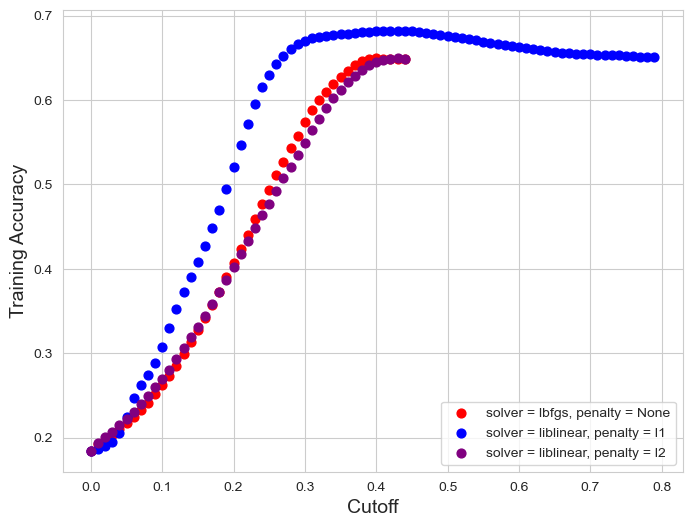

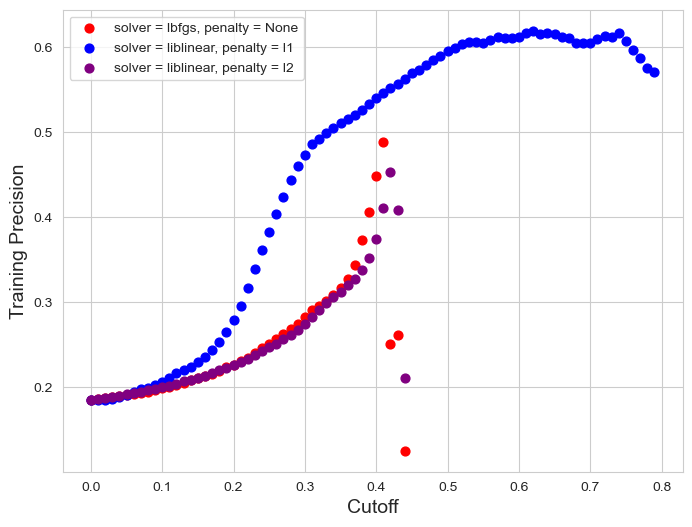

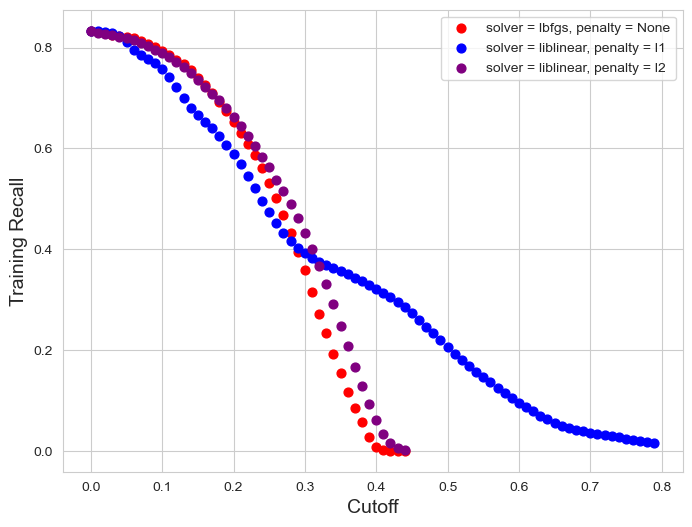

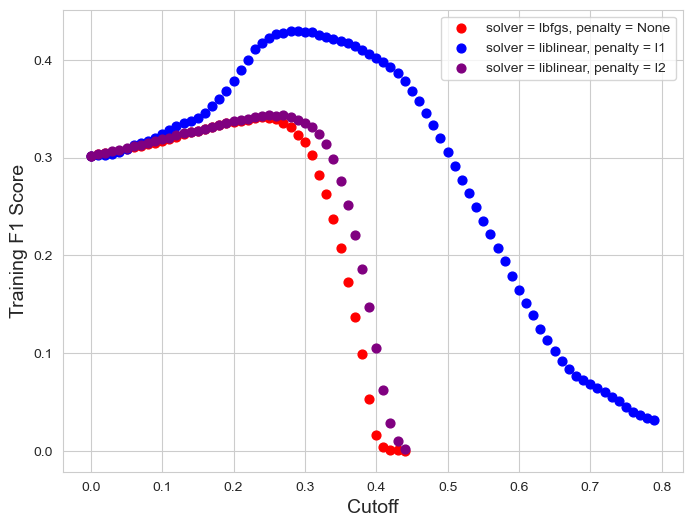

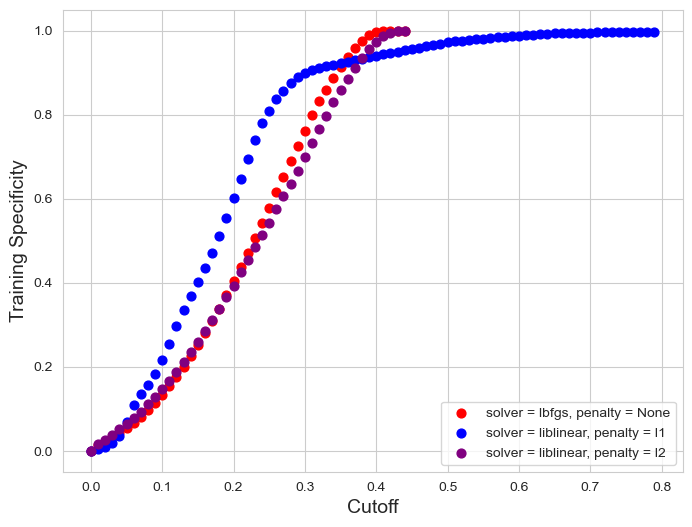

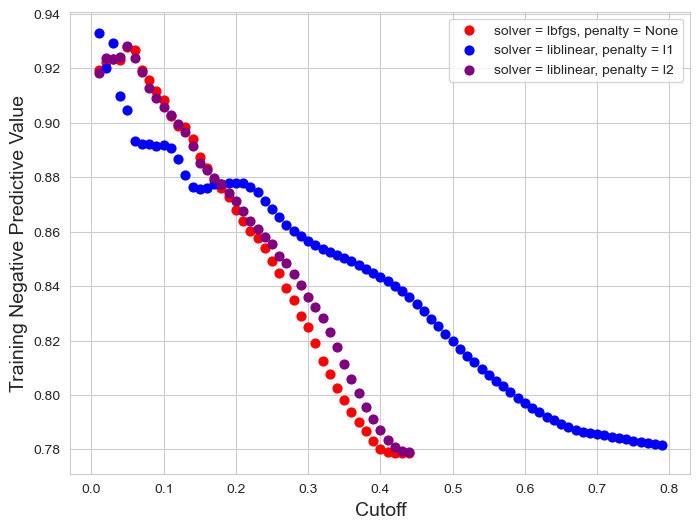

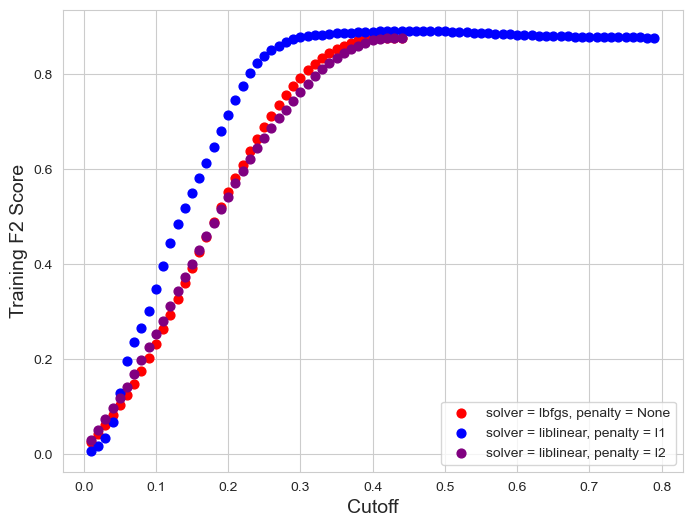

In [311]:
# 

lg1 = [
       {
        "penalty"      : None,
        "tol"          : 1e-4,
        "class_weight" : None,
        "solver"       : "lbfgs",
        "max_iter"     : 1000,
        "cutoff_min"   : 0.0,
        "cutoff_max"   : 0.45,
        "cutoff_step"  : 0.01,
        "color"        : "red",
        "marker"       : "o",
        "size"         : 40
       },
    
#        {
#         "penalty"      : None,
#         "tol"          : 1e-4,
#         "class_weight" : "balanced",
#         "solver"       : "lbfgs",
#         "max_iter"     : 1000,
#         "cutoff_min"   : 0.0,
#         "cutoff_max"   : 0.45,
#         "cutoff_step"  : 0.01,
#         "color"        : "orange",
#         "marker"       : "v",
#         "size"         : 40
#        },
    
       {
        "penalty"      : "l1",
        "tol"          : 1e-4,
        "class_weight" : None,
        "solver"       : "liblinear",
        "max_iter"     : 1000,
        "cutoff_min"   : 0.0,
        "cutoff_max"   : 0.8,
        "cutoff_step"  : 0.01,
        "color"        : "blue",
        "marker"       : "o",
        "size"         : 40
       },
    
#        {
#         "penalty"      : "l1",
#         "tol"          : 1e-4,
#         "class_weight" : "balanced",
#         "solver"       : "liblinear",
#         "max_iter"     : 1000,
#         "cutoff_min"   : 0.0,
#         "cutoff_max"   : 0.8,
#         "cutoff_step"  : 0.01,
#         "color"        : "green",
#         "marker"       : "v",
#         "size"         : 40
#        },
    
       {
        "penalty"      : "l2",
        "tol"          : 1e-4,
        "class_weight" : None,
        "solver"       : "liblinear",
        "max_iter"     : 1000,
        "cutoff_min"   : 0.0,
        "cutoff_max"   : 0.45,
        "cutoff_step"  : 0.01,
        "color"        : "purple",
        "marker"       : "o",
        "size"         : 40
       },
    
#        {
#         "penalty"      : "l2",
#         "tol"          : 1e-4,
#         "class_weight" : "balanced",
#         "solver"       : "liblinear",
#         "max_iter"     : 1000,
#         "cutoff_min"   : 0.0,
#         "cutoff_max"   : 0.45,
#         "cutoff_step"  : 0.01,
#         "color"        : "black",
#         "marker"       : "v",
#         "size"         : 40
#        },
      ]


colors = []
markers = []
sizes = []
j = 0

for lg in lg1:
    log_reg = LogisticRegression(penalty=lg["penalty"],tol=lg["tol"],solver=lg["solver"],max_iter=lg["max_iter"])
    lg["cutoffs"] = np.arange(lg["cutoff_min"],lg["cutoff_max"],lg["cutoff_step"])
    lg["avg_acc"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_prec"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_rec"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_F1"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_tn"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_fp"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_fn"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_tp"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_spec"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_NPV"] = np.zeros(shape=len(lg["cutoffs"]))
    lg["avg_F2"] = np.zeros(shape=len(lg["cutoffs"]))
    i = 1

    for train_index, test_index in kfold.split(data_train.drop(["DEFAULT"],axis=1),data_train.DEFAULT):
        log_reg.fit(data_train.iloc[train_index].drop(["DEFAULT"],axis=1),data_train.iloc[train_index].DEFAULT)
        y_prob = log_reg.predict_proba(data_train.iloc[train_index].drop(["DEFAULT"],axis=1))[:,1]

        accuracies = []
        precisions = []
        recalls = []
        tn = []
        fp = []
        fn = []
        tp = []

        for cutoff in lg["cutoffs"]:
            y_train_pred = 1*(y_prob >= cutoff)
            accuracies.append(np.sum(y_train_pred == data_train.iloc[train_index].DEFAULT)/len(data_train.iloc[train_index].DEFAULT))
            precisions.append(precision_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
            recalls.append(recall_score(data_train.iloc[train_index].DEFAULT,y_train_pred,zero_division=0.0))
            tn.append(confusion_matrix(data_train.iloc[train_index].DEFAULT,y_train_pred).ravel()[0])
            fp.append(confusion_matrix(data_train.iloc[train_index].DEFAULT,y_train_pred).ravel()[1])
            fn.append(confusion_matrix(data_train.iloc[train_index].DEFAULT,y_train_pred).ravel()[2])
            tp.append(confusion_matrix(data_train.iloc[train_index].DEFAULT,y_train_pred).ravel()[3])

        lg["avg_acc"] = lg["avg_acc"] + accuracies
        lg["avg_prec"] = lg["avg_prec"] + precisions
        lg["avg_rec"] = lg["avg_rec"] + recalls
        lg["avg_tn"] = lg["avg_tn"] + tn
        lg["avg_fp"] = lg["avg_fp"] + fp
        lg["avg_fn"] = lg["avg_fn"] + fn
        lg["avg_tp"] = lg["avg_tp"] + tp
        
        i = i + 1
    lg["avg_acc"] = lg["avg_acc"]/i
    lg["avg_prec"] = lg["avg_prec"]/i
    lg["avg_rec"] = lg["avg_rec"]/i
    lg["avg_F1"] = 2*(lg["avg_prec"]*lg["avg_rec"])/(lg["avg_prec"] + lg["avg_rec"])
    lg["avg_tn"] = lg["avg_tn"]/i
    lg["avg_fp"] = lg["avg_fp"]/i
    lg["avg_fn"] = lg["avg_fn"]/i
    lg["avg_tp"] = lg["avg_tp"]/i
    lg["avg_spec"] = (lg["avg_tn"]/(lg["avg_tn"]+lg["avg_fp"]))
    lg["avg_NPV"] = (lg["avg_tn"]/(lg["avg_tn"]+lg["avg_fn"]))
    lg["avg_F2"] = 2*(lg["avg_spec"]*lg["avg_NPV"])/(lg["avg_spec"] + lg["avg_NPV"])
    
    colors.append(lg["color"])
    markers.append(lg["marker"])
    sizes.append(lg["size"])
    j = j + 1



# colors = ["red","blue","green","purple"]
# markers = ["o","v","o","v"]
# sizes = [20,40,20,40]
fig_x = 8
fig_y = 6
x_font = 14
y_font = 14
leg_font = 10


plt.figure(figsize=(fig_x,fig_y))
k = 0

for lg in lg1:
#     lg["color"] = colors[k]
#     lg["marker"] = markers[k]
#     lg["size"] = sizes[k]
    
    plt.scatter(lg["cutoffs"],
                lg["avg_acc"],
                label = "solver = " + str(lg["solver"]) + ", penalty = " + str(lg["penalty"]),
                c = lg["color"],
                marker = lg["marker"],
                s = lg["size"]
               )
    k = k + 1


plt.xlabel("Cutoff",fontsize=x_font)
plt.ylabel("Training Accuracy",fontsize=y_font)
plt.legend(fontsize=leg_font)
plt.show()



plt.figure(figsize=(fig_x,fig_y))
k = 0

for lg in lg1:
#     lg["color"] = colors[k]
#     lg["marker"] = markers[k]
#     lg["size"] = sizes[k]
    
    plt.scatter(lg["cutoffs"],
                lg["avg_prec"],
                label = "solver = " + str(lg["solver"]) + ", penalty = " + str(lg["penalty"]),
                c = lg["color"],
                marker = lg["marker"],
                s = lg["size"]
               )
    k = k + 1


plt.xlabel("Cutoff",fontsize=x_font)
plt.ylabel("Training Precision",fontsize=y_font)
plt.legend(fontsize=leg_font)
plt.show()



plt.figure(figsize=(fig_x,fig_y))
k = 0

for lg in lg1:
#     lg["color"] = colors[k]
#     lg["marker"] = markers[k]
#     lg["size"] = sizes[k]
    
    plt.scatter(lg["cutoffs"],
                lg["avg_rec"],
                label = "solver = " + str(lg["solver"]) + ", penalty = " + str(lg["penalty"]),
                c = lg["color"],
                marker = lg["marker"],
                s = lg["size"]
               )
    k = k + 1


plt.xlabel("Cutoff",fontsize=x_font)
plt.ylabel("Training Recall",fontsize=y_font)
plt.legend(fontsize=leg_font)
plt.show()



plt.figure(figsize=(fig_x,fig_y))
k = 0

for lg in lg1:
#     lg["color"] = colors[k]
#     lg["marker"] = markers[k]
#     lg["size"] = sizes[k]
    
    plt.scatter(lg["cutoffs"],
                lg["avg_F1"],
                label = "solver = " + str(lg["solver"]) + ", penalty = " + str(lg["penalty"]),
                c = lg["color"],
                marker = lg["marker"],
                s = lg["size"]
               )
    k = k + 1


plt.xlabel("Cutoff",fontsize=x_font)
plt.ylabel("Training F1 Score",fontsize=y_font)
plt.legend(fontsize=leg_font)
plt.show()



plt.figure(figsize=(fig_x,fig_y))
k = 0

for lg in lg1:
#     lg["color"] = colors[k]
#     lg["marker"] = markers[k]
#     lg["size"] = sizes[k]
    
    plt.scatter(lg["cutoffs"],
                lg["avg_spec"],
                label = "solver = " + str(lg["solver"]) + ", penalty = " + str(lg["penalty"]),
                c = lg["color"],
                marker = lg["marker"],
                s = lg["size"]
               )
    k = k + 1


plt.xlabel("Cutoff",fontsize=x_font)
plt.ylabel("Training Specificity",fontsize=y_font)
plt.legend(fontsize=leg_font)
plt.show()



plt.figure(figsize=(fig_x,fig_y))
k = 0

for lg in lg1:
#     lg["color"] = colors[k]
#     lg["marker"] = markers[k]
#     lg["size"] = sizes[k]
    
    plt.scatter(lg["cutoffs"],
                lg["avg_NPV"],
                label = "solver = " + str(lg["solver"]) + ", penalty = " + str(lg["penalty"]),
                c = lg["color"],
                marker = lg["marker"],
                s = lg["size"]
               )
    k = k + 1


plt.xlabel("Cutoff",fontsize=x_font)
plt.ylabel("Training Negative Predictive Value",fontsize=y_font)
plt.legend(fontsize=leg_font)
plt.show()



plt.figure(figsize=(fig_x,fig_y))
k = 0

for lg in lg1:
#     lg["color"] = colors[k]
#     lg["marker"] = markers[k]
#     lg["size"] = sizes[k]
    
    plt.scatter(lg["cutoffs"],
                lg["avg_F2"],
                label = "solver = " + str(lg["solver"]) + ", penalty = " + str(lg["penalty"]),
                c = lg["color"],
                marker = lg["marker"],
                s = lg["size"]
               )
    k = k + 1


plt.xlabel("Cutoff",fontsize=x_font)
plt.ylabel("Training F2 Score",fontsize=y_font)
plt.legend(fontsize=leg_font)
plt.show()